In [2]:
%%writefile requirements.txt
torch
matplotlib
scikit-learn
diffusers
transformers
scipy
ftfy
accelerate

!%pip install -r requirements.txt

Overwriting requirements.txt


/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0128 17:26:53.256000 24502 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


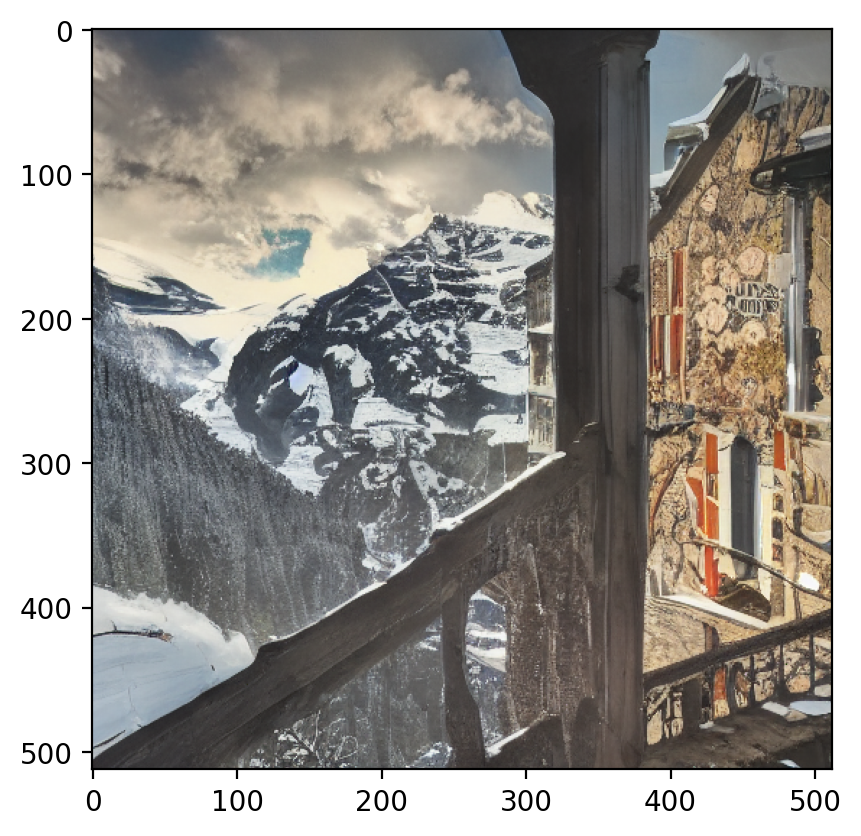

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' # make plots prettier

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DDIMScheduler
from tqdm.auto import tqdm
import torch
from diffusers import StableDiffusionPipeline

repo_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = "cpu"

vae = AutoencoderKL.from_pretrained(repo_id, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained(repo_id, subfolder="unet")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

scheduler = DDIMScheduler.from_pretrained(repo_id, subfolder="scheduler")

num_inference_steps = 100
scheduler.set_timesteps(num_inference_steps)

def get_text_embeddings(prompt):
    text_ids = tokenizer(
        prompt, 
        padding="max_length", 
        max_length=tokenizer.model_max_length, 
        truncation=True, 
        return_tensors="pt"
    ).input_ids

    with torch.no_grad():
        text_embeddings = text_encoder(text_ids)[0]
    
    return text_embeddings

# Prompt
prompt = "House of a Swiss Family in the Swiss Alps, scenic view, beautiful lighting, ultra detailed, 8k"

text_embeddings = get_text_embeddings(prompt)
text_embeddings.shape

# Configuration
height = 512
width = 512
batch_size = 1
in_channels = unet.config.in_channels

def get_latents():
    latents = torch.randn(
        (batch_size, in_channels, height // 8, width // 8),
        device=device
    )
    
    return latents

latents = get_latents()

###
for t in tqdm(scheduler.timesteps):
    latent_model_input = scheduler.scale_model_input(latents, t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    latents = scheduler.step(noise_pred, t, latents).prev_sample

###
latents = latents / vae.config.scaling_factor

with torch.no_grad():
    image = vae.decode(latents).sample

image.min(), image.max()
image = (image / 2 + 0.5).clamp(0, 1)
image.shape

plt.imshow(image[0].permute(1, 2, 0).detach().cpu())

In [ ]:
latents = get_latents()
text_embeddings_uncond = get_text_embeddings("") 
total_text_embeddings = torch.cat([text_embeddings_uncond, text_embeddings])

def diffusion_pipeline(orig_latents, s=1.0):
    latents = orig_latents.clone().to(device)
    total_embeddings = total_text_embeddings.to(device)
    
    for t in tqdm(scheduler.timesteps):
        latents_total = torch.cat([latents] * 2)
        latents_total = scheduler.scale_model_input(latents_total, t)

        with torch.no_grad():
            noise_pred = unet(latents_total, t, encoder_hidden_states=total_embeddings).sample

        noise_uncond, noise_text = noise_pred.chunk(2)
        noise_total = noise_uncond + s * (noise_text - noise_uncond)
        latents = scheduler.step(noise_total, t, latents).prev_sample

    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    return image[0].permute(1, 2, 0).detach().cpu().numpy()

s_options = [1.0, 7.5, 15.0] # 1.0 is no guidance, 7.5 is standard, 15.0 is heavy
images = [diffusion_pipeline(latents, s) for s in s_options]

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for i, (s, img) in enumerate(zip(s_options, images)):
    axs[i].imshow(img)
    axs[i].set_title(f"s = {s}")

 86%|████████▌ | 86/100 [06:14<01:04,  4.58s/it]